Как вы уже могли догадаться по названию, первый урок модуля посвящен оптимизации работы в Pandas!
В следующих степах мы посмотрим, какими способами можно итерироваться по датафреймам и применять операции к каждому элементу, а также определим, какие варианты являются наиболее эффективными. 

Начнем с самого простого. Логично предположить, что один из самых очевидных вариантов — использовать цикл и проитерироваться по всему датафрейму, применив нужную операцию к каждой строчке.     

Первый метод — pd.iterrows(), на каждой итерации возвращает строку датафрейма в виде пар (index, series), где первый элемент является индексом, а содержимое самого ряда представляется в виде Series. Таким образом, можно использовать его в цикле, например:     

```
for index, row in df[:1].iterrows():
    print(f"Тип индекса: {type(index)},\nТип содержимого строки: {type(row)}")
```   
```
Тип индекса: < class 'int' >,
ип содержимого строки: < class 'pandas.core.series.Series' >
```   

Посмотрим, в каком формате возвращается содержимое строки:

```
for index, row in df[:2].iterrows():
    print("Индекс: {},\nСодержимое строки:\n{}\n".format(index, row))
Индекс: 0,
Содержимое строки:
key                  2009-06-15 17:26:21.0000001
fare_amount                                  4.5
pickup_datetime        2009-06-15 17:26:21+00:00
pickup_longitude                        -73.8443
pickup_latitude                          40.7213
dropoff_longitude                       -73.8416
dropoff_latitude                         40.7123
passenger_count                                1
Name: 0, dtype: object

Индекс: 1,
Содержимое строки:
key                  2010-01-05 16:52:16.0000002
fare_amount                                 16.9
pickup_datetime        2010-01-05 16:52:16+00:00
pickup_longitude                         -74.016
pickup_latitude                          40.7113
dropoff_longitude                       -73.9793
dropoff_latitude                          40.782
passenger_count                                1
Name: 1, dtype: object
```

К конкретным колонкам тоже можно обратиться. Так, выведем индекс и число пассажиров для первых трех наблюдений:

```
for index, row in df[:3].iterrows():
    print("Индекс {}; Число пассажиров: {}".format(index, row['passenger_count']))
Индекс 0; Число пассажиров: 1
Индекс 1; Число пассажиров: 1
Индекс 2; Число пассажиров: 2
```
 Этот метод является одним из наименее эффективных, подробнее о причинах можно почитать вот здесь. Тем не менее, работает быстрее, чем самые обычные циклы.


1. Перейдем к практике!
Представьте, что вы аналитик в сервисе такси. Ваша задача – написать функцию haversine для подсчета расстояния между пунктами отправления и прибытия и, используя  pd.iterrows(), создать колонку distance с подсчитанным расстоянием. Более подробно ознакомиться с формулой можно здесь.

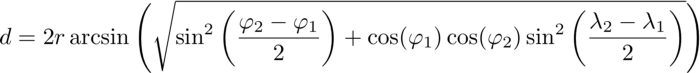
где:

- $$φ1,φ2$$- широта   исходного   местоположения и широта пункта назначения в радианах
- $$ λ1, λ2$$-долгота исходного местоположения и долгота пункта назначения в радианах,
- r — радиус сферы, будем считать его равным 6371.

Таким образом, сама функция haversine() должна принимать на вход 5 параметров, один из которых должен иметь значение по умолчанию.
~~~
def haversine(..., ..., ..., ..., radius=6371):
    # ваш код
~~~
Саму функцию можно применить как используя обычный цикл...

~~~
dists = [ ]
for i, row in df.iterrows():
    dists.append(haversine(row['...'], ..., ..., ...))
df['distance'] = dists
~~~

...так и используя более компактный вариант:

~~~
df['distance'] = pd.Series(haversine(row['...'], ..., ..., ...) for i, row in df.iterrows())
~~~

Датасет, с которым мы будем работать – данные о поездках в Нью-Йорке. Он уже сохранен в переменную nyc, но вы можете самостоятельно подгрузить его отсюда и потренироваться у себя в ноутбуке. Сам он является небольшой частью большего датасета. 

- pickup_datetime — дата начала поездки
- pickup_longitude — долгота исходного местоположения
- pickup_latitude — широта исходного местоположения
- dropoff_longitude — долгота пункта назначения
- dropoff_latitude — широта пункта назначения
- fare_amount — стоимость поездки в долларах 
- passenger_count — число пассажиров           

Для того, чтобы оценить скорость выполнения операции, воспользуйтесь magic-функцией %timeit (или %%time), поместив её в начало ячейки. В дальнейшем результаты её выполнения позволят нам сравнить изученные методы и понять, какой из них справляется быстрее. В код решения её добавлять не нужно.


In [7]:
import pandas as pd
import numpy as np

nyc =  pd.read_csv('https://stepik.org/media/attachments/lesson/363873/nyc.csv.zip')
def haversine(pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude, radius=6371):
    fi_1 = np.deg2rad(pickup_latitude)
    fi_2 = np.deg2rad(dropoff_latitude)
    delta_fi = np.deg2rad(dropoff_latitude) - np.deg2rad(pickup_latitude)
    delta_l = np.deg2rad(dropoff_longitude) - np.deg2rad(pickup_longitude)
    a = np.sin(delta_fi/ 2) ** 2 + np.cos(fi_1) * np.cos(fi_2) * (np.sin(delta_l / 2) ** 2)
    c = 2 * np.arcsin(np.sqrt(a))
    return radius * c


nyc['distance'] = pd.Series(haversine(row['pickup_longitude'],
                                      row['pickup_latitude'],
                                      row['dropoff_longitude'],
                                      row['dropoff_latitude']) for i, row in nyc.iterrows())
nyc.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1,1.030764
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1,8.450134
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2,1.389525
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1,2.799270
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1,1.999157


2. На первый взгляд, pd.iterrows() вполне хорошо справляется со своей задачей и выполнение операции не занимает много времени!  

Давайте попробуем еще один метод, pd.itertuples, который на каждой итерации возвращает именованный кортеж (named tuple) для каждой строки датафрейма. Параметр index по умолчанию равен True, поэтому первым элементом кортежа следует индекс, далее — содержимое строки. 

Обратите внимание, что, в отличие от первого метода, строка возвращается уже не как Series:

~~~
for row in df[:1].itertuples(name='ride'):  # исп. "ride" как название
    print(f"Тип содержимого: {type(row)}")
~~~
~~~
Тип содержимого: < class 'pandas.core.frame.ride' >
~~~

Посмотрим на формат вывода:

~~~
for row in df[:3].itertuples(name='custom_name'):
    print(row)
custom_name(Index=0, key='2009-06-15 17:26:21.0000001', fare_amount=4.5, pickup_datetime=Timestamp('2009-06-15 17:26:21+0000', tz='UTC'), pickup_longitude=-73.844311, pickup_latitude=40.721319, dropoff_longitude=-73.84161, dropoff_latitude=40.71227800000001, passenger_count=1)
custom_name(Index=1, key='2010-01-05 16:52:16.0000002', fare_amount=16.9, pickup_datetime=Timestamp('2010-01-05 16:52:16+0000', tz='UTC'), pickup_longitude=-74.016048, pickup_latitude=40.711303, dropoff_longitude=-73.979268, dropoff_latitude=40.782004, passenger_count=1)
custom_name(Index=2, key='2011-08-18 00:35:00.00000049', fare_amount=5.7, pickup_datetime=Timestamp('2011-08-18 00:35:00+0000', tz='UTC'), pickup_longitude=-73.982738, pickup_latitude=40.76127, dropoff_longitude=-73.991242, dropoff_latitude=40.750562, passenger_count=2)
Индекс и число пассажиров для первых трех наблюдений:

for row in df[:3].itertuples():
    print("Индекс {}; Число пассажиров: {}".format(row.Index, row.passenger_count))
Индекс 0; Число пассажиров: 1
Индекс 1; Число пассажиров: 1
Индекс 2; Число пассажиров: 2
~~~

Задача: проделайте ту же операцию, что и в предыдущем степе, но уже используя pd.itertuples(), а затем сравните время выполнения.

In [10]:
def haversine_2(pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude, radius=6371):
    fi_1 = np.deg2rad(pickup_latitude)
    fi_2 = np.deg2rad(dropoff_latitude)
    delta_fi = np.deg2rad(dropoff_latitude) - np.deg2rad(pickup_latitude)
    delta_l = np.deg2rad(dropoff_longitude) - np.deg2rad(pickup_longitude)
    a = np.sin(delta_fi/ 2) ** 2 + np.cos(fi_1) * np.cos(fi_2) * (np.sin(delta_l / 2) ** 2)
    c = 2 * np.arcsin(np.sqrt(a))
    return radius * c

nyc['distance'] = pd.Series(haversine_2(row.pickup_longitude,
                                      row.pickup_latitude,
                                      row.dropoff_longitude, 
                                      row.dropoff_latitude) for row in nyc.itertuples())
nyc.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,distance_2
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1,1.030764,1.030764
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1,8.450134,8.450134
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2,1.389525,1.389525
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1,2.799270,2.799270
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1,1.999157,1.999157


3. Еще один часто используемый метод pd.apply() применяет заданную функцию вдоль определенной оси (axis=0 – строки; axis=1 – столбцы), и является более эффективным способом, чем pd.iterrows() за счет использования внутренних оптимизаций в pandas. Тем не менее, все равно подразумевает итерацию по всем рядам.

~~~ 
df['distance'] = df[['col1', 'col2', 'col3', 'col4']].apply(lambda row: haversine(row[0], row[1], row[2], row[3]), axis=1)
~~~
~~~
# более медленный вариант
df['distance'] = df.apply(lambda x: haversine(x['col1'], x['col2'], x['col3'], x['col4']), axis=1)
~~~

В столбец distance датафрейма nyc сохраните результат подсчета расстояния между точками отправки и прибытия, используя написанную ранее функцию. В переменную longest сохраните самое большое расстояние. Не забудьте проверить скорость выполнения операции (в код включать не нужно)! 

In [14]:
# переменная nyc уже создана
def haversine_3(pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude, radius=6371):
    fi_1 = np.deg2rad(pickup_latitude)
    fi_2 = np.deg2rad(dropoff_latitude)
    delta_fi = np.deg2rad(dropoff_latitude) - np.deg2rad(pickup_latitude)
    delta_l = np.deg2rad(dropoff_longitude) - np.deg2rad(pickup_longitude)
    a = np.sin(delta_fi/ 2) ** 2 + np.cos(fi_1) * np.cos(fi_2) * (np.sin(delta_l / 2) ** 2)
    c = 2 * np.arcsin(np.sqrt(a))
    return float(radius * c)

nyc['distance'] = nyc[['pickup_longitude',
                         'pickup_latitude',
                         'dropoff_longitude', 
                         'dropoff_latitude']].apply(lambda row:
                               haversine_3(row.pickup_longitude,
                                      row.pickup_latitude,
                                      row.dropoff_longitude, 
                                      row.dropoff_latitude), axis=1)
longest = nyc.distance.max()
longest

8667.818812217458

4. В целом, *itertuples* — это именно то, что нам нужно! Но есть пара моментов.

Оказывается, в нашем случае itertuples — не предел. На всех предыдущих шагах мы использовали циклы, что не очень хорошо. Почему же?

Базовые объекты в pandas — Series и DataFrame, которые представляют собой одномерные и двумерные массивы (arrays) соответственно. Так, векторизация — процесс выполнения операций над массивами. В pandas есть довольно большой набор векторизованных функций, и их использование во многих случаях предпочтительнее обычных циклов, поскольку они предназначены для работы именно с Series. К таким функциям относятся, например, sum и agg. С помощью векторизации можно получить ещё большее ускорение, значительно уменьшив количество итераций. Иными словами, действия будут происходят сразу над всей серией, а не над каждым элементом по отдельности.

Изменения в коде весьма незначительны: передаем функции на вход необходимые колонки, и получается магия!

~~~ 
df['distance'] = haversine(df['col1'], df['col2'], df['col3'], df['col4'])
~~~

Убедимся, что векторизованные операции работают намного быстрее! Создайте функцию для подсчета расстояния haversine, описанную в первом степе, и примените её к датасету nyc. Результат сохраните в колонку distance. 

In [15]:
def haversine_4(pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude, radius=6371):
    fi_1 = np.deg2rad(pickup_latitude)
    fi_2 = np.deg2rad(dropoff_latitude)
    delta_fi = np.deg2rad(dropoff_latitude) - np.deg2rad(pickup_latitude)
    delta_l = np.deg2rad(dropoff_longitude) - np.deg2rad(pickup_longitude)
    a = np.sin(delta_fi/ 2) ** 2 + np.cos(fi_1) * np.cos(fi_2) * (np.sin(delta_l / 2) ** 2)
    c = 2 * np.arcsin(np.sqrt(a))
    return radius * c

nyc['distance'] = haversine_4(nyc['pickup_longitude'],
                            nyc['pickup_latitude'],
                            nyc['dropoff_longitude'], 
                            nyc['dropoff_latitude'])

5. Don't stop me now, можно еще быстрее! Опять же, все довольно просто.

В предыдущем степе мы передавали функции колонки формата Series, с чем связаны дополнительные вычислительные затраты, например, индексирование и проверка типа данных. Чтобы этого избежать, в качестве аргументов функции можно передать всё те же необходимые колонки, дополнительно указав .values, чтобы из Series получить массив NumPy (numpy array). В таком случае действия будут выполняться непосредственно над ndarrays. Такой способ можно использовать, когда отсутствие индексов и пр. не приведет к нарушению работы применяемой функции. 

~~~
df['distance'] = haversine(df['col1'].values, df['col2'].values, df['col3'].values, df['col4'].values)
~~~

Как выглядят данные такого формата? 
~~~
df.pickup_longitude.values
array([-73.844311, -74.016048, -73.982738, ..., -74.002698, -73.946062,
   -73.932603])
~~~

Создайте функцию для подсчета расстояния haversine, описанную в первом степе, и примените её к датасету nyc. Результат сохраните в колонку distance.

In [16]:
def haversine_5(pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude, radius=6371):
    fi_1 = np.deg2rad(pickup_latitude)
    fi_2 = np.deg2rad(dropoff_latitude)
    delta_fi = np.deg2rad(dropoff_latitude) - np.deg2rad(pickup_latitude)
    delta_l = np.deg2rad(dropoff_longitude) - np.deg2rad(pickup_longitude)
    a = np.sin(delta_fi/ 2) ** 2 + np.cos(fi_1) * np.cos(fi_2) * (np.sin(delta_l / 2) ** 2)
    c = 2 * np.arcsin(np.sqrt(a))
    return radius * c

nyc['distance'] = haversine_5(nyc['pickup_longitude'].values,
                            nyc['pickup_latitude'].values,
                            nyc['dropoff_longitude'].values, 
                            nyc['dropoff_latitude'].values)

7. Изучите документацию к рассмотренным методам и выберите верные утверждения.

    - iterrows
    - itertuples
    - apply     
    
**Выберите все подходящие ответы из списка**    

   - pd.apply() всегда работает быстрее
   - Если параметр index в pd.iterrows() равен True, то первым элементом кортежа возвращается индекс
   - **Параметр name в pd.itertuples() отвечает за название именованного кортежа**
   - **pd.iterrows() предназначен для того, чтобы считывать данные, поэтому генератор (iterator) возвращает копию оригинального объекта, и изменения никак не отразятся на изначальном объекте**
   - pd.iterrows() является самым эффективным методом


8. Давайте подробнее посмотрим на информацию о самой длинной поездке в датасете nyc с 50 000 наблюдений.

key                  2012-05-12 10:48:00.00000020  
fare_amount                                  49.8   
pickup_datetime         2012-05-12 10:48:00+00:00   
pickup_longitude                         -74.0149   
pickup_latitude                           40.7134   
dropoff_longitude                               0   
dropoff_latitude                                0   
passenger_count                                 1   
distance                                  8667.82   
Name: 48996, dtype: object   

~~~
Как вы уже заметили, произошло что-то странное: в качестве широты и долготы стоят нулевые значения, а расстояние — целых 8667 км! Неужели наш пассажир действительно уехал так далеко?

Посмотрите, есть ли еще кейсы, где в качестве хотя бы одной из координат пункта назначения стоят нули, и в качестве ответа укажите количество таких случаев.

In [20]:
nyc.query('dropoff_longitude == 0' or 'dropoff_latitude == 0').count()

key                  958
fare_amount          958
pickup_datetime      958
pickup_longitude     958
pickup_latitude      958
dropoff_longitude    958
dropoff_latitude     958
passenger_count      958
distance             958
distance_2           958
dtype: int64

9. Предположим, наша цель всё ещё состоит в поиске самых дальних поездок. Естественно, текущие данные совсем не годятся — некоторые такси, согласно данным, уезжают и приезжают из океана.

hp_meme

Постройте графики распределения переменных pickup_latitude, pickup_longitude, dropoff_latitude, dropoff_longitude, и для каждой переменной выберите только один наиболее подходящий вариант для дальнейшей фильтрации данных (в итоге – 4 галочки).

- **pickup_longitude < -60**

- pickup_latitude > 0

- pickup_longitude < 0

- **10 < pickup_latitude < 120**

- dropoff_longitude < 20

- **dropoff_longitude < -60**

- **10 < dropoff_latitude**

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f09392698d0>,
      dtype=object)

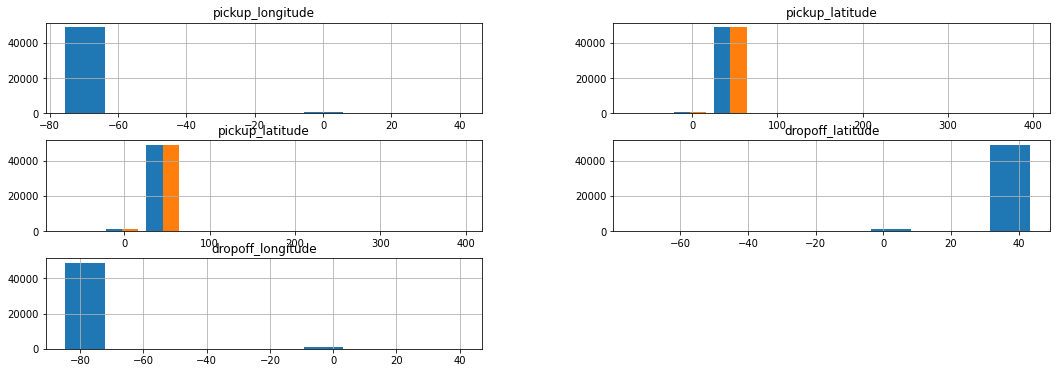

In [27]:
nyc[['pickup_longitude','pickup_latitude', 'pickup_latitude', 'dropoff_latitude', 'dropoff_longitude']].hist(figsize = (18, 6))

10. Критерии для фильтрации выбраны, остался последний шаг: отфильтровать имеющиеся данные и наконец-то найти самую дальнюю поездку.

Для фильтрации используйте условия из предыдущего степа, а также добавьте еще одно ограничение для переменной distance. Предположим, максимальная удаленность пунктов друг от друга не должна превышать 50 километров, иначе такой заказ не будет принят системой, а наличие подобных результатов в таблице будет считаться ошибкой.

В качестве ответа укажите сумму, которую заплатил пассажир, проехавший наибольшее расстояние.

In [66]:
nyc.query('distance < 50')\
   .query( 'pickup_longitude < -60'and 'pickup_latitude < 120')\
   .query('pickup_latitude > 10' and 'dropoff_latitude > 10' and 'dropoff_longitude < -60')\
   .sort_values('distance', ascending = False).fare_amount[:1]

33502    136.0
Name: fare_amount, dtype: float64